In [1]:
import numpy as np
import mne
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from pandas import DataFrame

%load_ext rpy2.ipython
%matplotlib inline
plt.rc('figure', figsize=(16, 12))
rng = np.random.RandomState(12345)

# Set up experiment properties
For this example, we'll simulate some EEG data for 12 subjects and 2 conditions ("noun" and "verb"). Each condition will consist of 20 items, with 10 repetitions per item. For simplicity we'll only do a single channel, since we'll be reducing it back down to a scalar (alpha band power) anyway.

In [2]:
# various data parameters
subjs = range(12)
conds = ['noun', 'verb']
nouns = ['time', 'year', 'people', 'way', 'day', 'man', 'thing', 'woman',
         'life', 'child', 'world', 'school', 'state', 'family', 'student',
         'group', 'country', 'problem', 'hand', 'part']
verbs = ['be', 'have', 'do', 'say', 'go', 'get', 'make', 'know', 'see', 
         'say', 'think', 'come', 'want', 'use', 'find', 'give', 'tell', 
         'work', 'call', 'try']
words = nouns + verbs
trials_per_word = 10
trials = range(len(words) * trials_per_word)

These are the properties our epochs will have...

In [3]:
# signal parameters
# channels = range(32)  # not yet implemented
fs = 1000
epoch_dur = 2.

Next we'll specify the parameters of the model that we'll be trying to recover later. Since we're modeling "alpha power", these variables determine what the alpha power will be for a given subject/trial combination.  For example, in `cond_intercepts` we're specifying that nouns, on average, will have alpha power that is 7 units greater than verbs, and additionally (in `word_intercepts`) specifying some per-word random deviations from those condition averages.

In [4]:
global_intercept = 100
cond_intercepts = np.repeat([7, 0], [len(nouns), len(verbs)])
word_intercepts = rng.randn(len(words)) * 1.5
# pre-combine condition and word effects into a single offset, and tile it to get total number of trials
trial_intercepts = np.tile(cond_intercepts + word_intercepts, trials_per_word)

subj_intercepts = rng.randn(len(subjs)) * 4
subj_noise = np.exp(1 + rng.randn(len(subjs)))  # TODO: this is being added as an intercept,
                                                # but should really be a subject-level variance?
eps = rng.randn(len(subjs), len(trials))

 We also specified in `subj_intercepts` that each subject will vary in her overall alpha power (e.g., because of differences in alertness, skull thickness, etc), and add in some noise. Now we're ready to compute the alpha power values for each epoch:

In [5]:
alpha_powers = (global_intercept + 
                subj_intercepts[:, np.newaxis] + 
                trial_intercepts[np.newaxis, :] +
                subj_noise[:, np.newaxis] * eps)

# Generate signals
Next we generate the actual signals.  As mentioned above, for simplicity we're just doing a single channel, since we're going to reduce it back down to alpha-band power anyway.

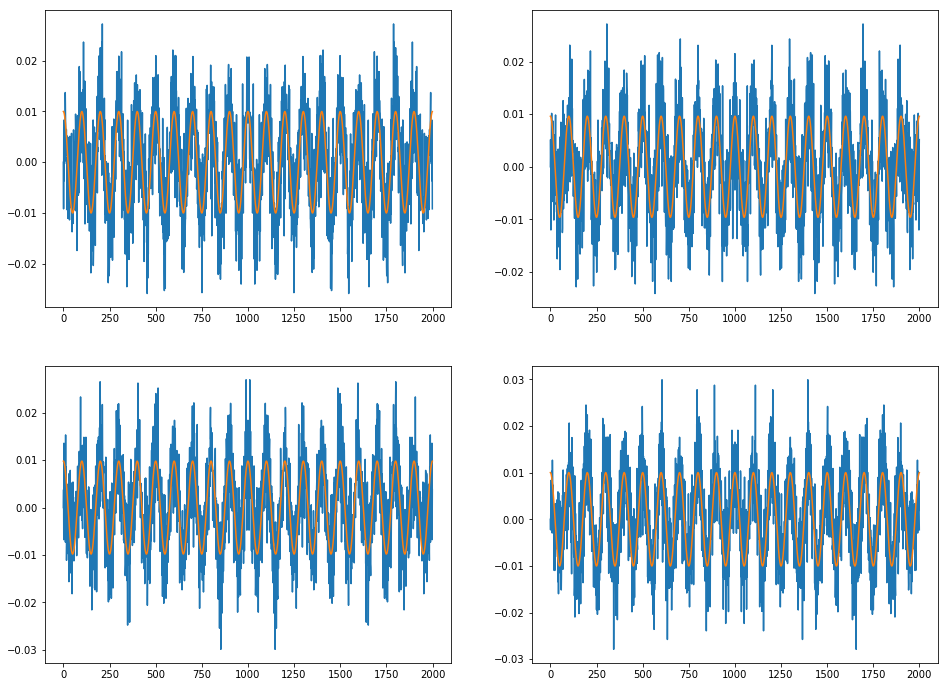

In [6]:
times = np.linspace(0, epoch_dur, int(epoch_dur * fs))
#signal = np.empty((len(subjs), len(trials), len(times)))

fourier_freqs = np.fft.rfftfreq(len(times), d=1/fs)
alpha_freqs = np.where(np.logical_and(fourier_freqs > 8, fourier_freqs < 12))[0]
not_alpha_freqs = np.where(np.logical_or(fourier_freqs < 7, fourier_freqs > 13))[0]
fourier_coefs = np.zeros((len(subjs), len(trials), len(fourier_freqs)))
# for simplicity, just put all the power in a single frequency bin near the middle of the alpha band
freq_bin = len(alpha_freqs) // 2
fourier_coefs[:, :, alpha_freqs[freq_bin]] = np.sqrt(alpha_powers)

# generate the signals
signal = np.fft.irfft(fourier_coefs, axis=-1)

# make sure we didn't screw up:
powr = np.fft.rfft(signal, axis=-1)
powr = (powr * powr).sum(axis=-1)
assert np.allclose(alpha_powers, powr)

# add some energy outside alpha band
coefs = rng.rand(len(subjs) * len(trials) * len(not_alpha_freqs)).reshape(len(subjs), len(trials), -1)
fourier_coefs[:, :, not_alpha_freqs] = coefs
signal_plus_noise = np.fft.irfft(fourier_coefs, axis=-1)
signal_plus_noise[:, :, 0] = 0.  # hack to avoid cosine phase issue

# TODO: signal appears the same in all trials below
# plot a few trials, just to see
fig, axs = plt.subplots(2, 2)
for trial, ax in zip([0, 20, 50, 90], axs.ravel()):
    ax.plot(signal_plus_noise[0, trial, :])
    ax.plot(signal[0, trial, :])

# Generate `Epochs` objects
Now that we have some (fake) data, let's get it into `mne-python` format.  If you're working with real data, you would skip all the synthesis above and start here.

In [7]:
# TODO: create event dict, etc
# info = XXX
# events = np.zeros((len(trials), 3))
# event_id = dict()
# epochs = mne.epochs.EpochsArray(signal_plus_noise, info, events, proj=False)
# TODO: Recover alpha power from noisy signals

# Convert data to long form for modeling
For now, we'll skip all the signal / epoch generation above, and just work with the generated alpha powers (on the assumption that they would have been recovered more or less as-is from the noisy signals).  When the signal/epoch generation code above is completed, we'll swap in `recovered_alpha_powers` for `alpha_powers` in what follows.

In [8]:
variables = dict(alpha_power=alpha_powers.ravel(),
                 subj=np.repeat(subjs, len(trials)),
                 word=np.tile(words, len(subjs) * trials_per_word),
                 cond=np.tile(np.repeat(conds, [len(nouns), len(verbs)]), len(subjs) * trials_per_word))

dfrm = DataFrame(variables)

# Do the stats

First, we will consider the following **mixed-effects model**:

\begin{equation}
  \log y_{c,j,i} = \beta_0 + \beta_c + \beta_j + \epsilon_{c,j,i}
\end{equation}

Where $\epsilon_{c,j,i} \sim \mathcal{N}(0, \sigma_j)$.

**TODO** add more explanation

In [9]:
md = smf.mixedlm("alpha_power ~ cond", dfrm, groups=dfrm['subj'])
fitmod_py = md.fit() 
print(fitmod_py.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: alpha_power
No. Observations:   4800    Method:             REML       
No. Groups:         12      Scale:              26.1812    
Min. group size:    400     Likelihood:         -14679.4752
Max. group size:    400     Converged:          Yes        
Mean group size:    400.0                                  
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    105.880    1.216  87.077 0.000 103.497 108.263
cond[T.verb]  -7.709    0.148 -52.193 0.000  -7.999  -7.420
groups RE     17.611    1.479                              



# Run the same model in R

In [10]:
%%R -i dfrm
library(lme4)
fitmod_r <- lmer(alpha_power ~ cond + (1|subj), data=dfrm)
summary(fitmod_r)

/home/drmccloy/miniconda3/envs/p3mne/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


Linear mixed model fit by REML ['lmerMod']
Formula: alpha_power ~ cond + (1 | subj)
   Data: dfrm

REML criterion at convergence: 29359

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5360 -0.5067  0.0025  0.4649  5.5365 

Random effects:
 Groups   Name        Variance Std.Dev.
 subj     (Intercept) 17.56    4.190   
 Residual             26.18    5.117   
Number of obs: 4800, groups:  subj, 12

Fixed effects:
            Estimate Std. Error t value
(Intercept) 105.8801     1.2142   87.21
condverb     -7.7093     0.1477  -52.19

Correlation of Fixed Effects:
         (Intr)
condverb -0.061
